In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import glob
import time
warnings.filterwarnings('ignore')

In [2]:
#cube_image = xr.open_mfdataset(glob.glob("/home/jovyan/work/datacube/ESDCv1.0.2_1/esdc-8d-0.083deg-1x2160x4320-1.0.2_1/data/*/*.nc"))

In [3]:
#cube_time = xr.open_mfdataset(glob.glob("/home/jovyan/work/datacube/ESDCv1.0.2_1/esdc-8d-0.083deg-46x270x270-1.0.2_1/data/*/*.nc"))

In [4]:
cube_zarr_image = xr.open_zarr("/home/jovyan/work/datacube/ESDCv1.0.2_2/esdc-8d-0.083deg-1x2160x4320-1.0.2_2.zarr")

In [5]:
#cube_time = xr.open_mfdataset(glob.glob("/home/jovyan/work/datacube/ESDCv1.0.2_1/esdc-8d-0.083deg-46x270x270-1.0.2_1/data/")

In [6]:
def random_date(start, end):
    """Generate a random datetime between `start` and `end`"""
    return start + datetime.timedelta(
        # Get a random amount of seconds between `start` and `end`
        seconds=np.random.randint(0, int((end - start).total_seconds())),
    )

In [7]:
def random_latlon(latmin, latmax, lonmin, lonmax, start, stop, N=1):
    rlat = np.random.uniform(latmin,latmax, size=N)
    rlon = np.random.uniform(lonmin,lonmax, size=N)
    rt = [random_date(start, stop) for i in range(N)]
    return rlat, rlon, rt

In [8]:
t0 = time.time()
N=250
lats, lons, times = random_latlon(-90.,90.,-180.,180.,datetime.datetime.strptime('2001-05-01','%Y-%m-%d'),datetime.datetime.strptime('2010-05-01','%Y-%m-%d'),N)
print(time.time()-t0)

0.005332469940185547


# slow sel element-wise

In [9]:
t0 = time.time()
res = np.zeros(N)
for i in range(N):
    res[i]=(cube_zarr_image.evaporation.sel(dict(lat=lats[i], lon = lons[i], time=times[i]), method='nearest').values)
print(time.time()-t0)

22.57008171081543


# faster sel with dataarrays

In [10]:
lonx = xr.DataArray(lons,dims='i')
latx = xr.DataArray(lats,dims='i')
timex = xr.DataArray(times,dims='i')

In [11]:
t0 = time.time()
res2 = cube_zarr_image.evaporation.sel(lat=latx,lon=lonx,time=timex, method='nearest')
res2.values
print(time.time()-t0)

3.5970458984375


In [12]:
xr.DataArray(res-res2.values).sum()

<xarray.DataArray ()>
array(0.0)

# querying a cube by index

In [13]:
cube_zarr_image.indexes['lon'].get_loc(8.90, method = 'nearest')

2266

# slow get_loc

In [14]:
%time ilon = [cube_zarr_image.indexes['lon'].get_loc(i, method = 'nearest') for i in lonx]

CPU times: user 1min 44s, sys: 0 ns, total: 1min 44s
Wall time: 1min 44s


# fast look-up for regular grids, also for reversed coordinates, to be extended for time

In [15]:
def bisection(array,value):
    '''Given an ``array`` , and given a ``value`` , returns an index j such that ``value`` is between array[j]
    and array[j+1]. ``array`` must be monotonic increasing. j=-1 or j=len(array) is returned
    to indicate that ``value`` is out of range below and above respectively.'''
    if (all(x <= y for x,y in zip(array, array[1:]))):
        asc = True
        #print(asc)
    elif(all(x <= y for x,y in zip(array[::-1], array[1::-1]))):
        asc=False
        array = array[::-1]
        #print(asc,array[0],value)
    else: 
        print("Err")
        
    n = len(array)
    if (value < array[0]):
        if asc:
            return -1
        else: 
            return -1
    elif (value > array[n-1]):
        if asc:
            return -1
        else:
            return -1
    jl = 0# Initialize lower
    ju = n-1# and upper limits.
    while (ju-jl > 1):# If we are not yet done,
        jm=(ju+jl) >> 1# compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm# and replace either the lower limit
        else:
            ju=jm# or the upper limit, as appropriate.
        # Repeat until the test condition is satisfied.
    if (value == array[0]):# edge cases at bottom
        if asc:
            return 0
        else: 
            return n-1
    elif (value == array[n-1]):# and top
        if asc:
            return n-1
        else: 
            return 0
    else:
       #print(asc, jl,value, array[jl],array[jl+1],value - array[jl], array[jl+1] -value)
        if (value - array[jl] < array[jl+1] -value):
            if asc:
                return jl
            else:
                #print("here", jl, len(array)-jl-1)
                return len(array)-jl-1
        else: 
            if asc: 
                return jl+1
            else:
                return len(array)-jl-2

# Get nearest index for lat and lon

In [37]:
lon_ = cube_zarr_image.lon.values

In [38]:
%time ilon2 = [bisection(lon_,i) for i in lonx]

CPU times: user 836 ms, sys: 0 ns, total: 836 ms
Wall time: 833 ms


In [17]:
lonx

<xarray.DataArray (i: 250)>
array([-11.746249, -33.300866, -98.546583, ..., -82.804483,  86.566093,
        74.523492])
Dimensions without coordinates: i

In [18]:
cube_zarr_image.lon[ilon2]

<xarray.DataArray 'lon' (lon: 250)>
array([-11.709006, -33.292255, -98.541992, ..., -82.792053,  86.540604,
        74.540649], dtype=float32)
Coordinates:
  * lon      (lon) float32 -11.709 -33.2923 -98.542 -162.542 -64.0421 ...
Attributes:
    bounds:         lon_bnds
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [19]:
%time ilat2 = [bisection(cube_zarr_image.lat.values,i) for i in latx]

CPU times: user 764 ms, sys: 0 ns, total: 764 ms
Wall time: 759 ms


In [20]:
latx

<xarray.DataArray (i: 250)>
array([  4.593256, -40.56802 ,  59.048253, ...,  28.367517, -84.947019,
         7.976279])
Dimensions without coordinates: i

In [21]:
cube_zarr_image.lat[ilat2]

<xarray.DataArray 'lat' (lat: 250)>
array([  4.625341, -40.541145,  59.04179 , ...,  28.375246, -84.957634,
         7.958662], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.62534 -40.5411 59.0418 13.4586 -64.291 -76.3743 ...
Attributes:
    bounds:         lat_bnds
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

# unwanted: creates unsorted array with len(lat)xlen(lon)

In [22]:
cube_zarr_image.evaporation[0,ilat2,ilon2]

<xarray.DataArray 'evaporation' (lat: 250, lon: 250)>
dask.array<shape=(250, 250), dtype=float32, chunksize=(250, 250)>
Coordinates:
  * lat      (lat) float32 4.62534 -40.5411 59.0418 13.4586 -64.291 -76.3743 ...
  * lon      (lon) float32 -11.709 -33.2923 -98.542 -162.542 -64.0421 ...
    time     datetime64[ns] 1980-01-05
Attributes:
    long_name:      Evaporation
    project_name:   GLEAM
    references:     Martens, B., Miralles, D.G., Lievens, H., van der Schalie...
    source_name:    E
    standard_name:  water_evaporation_flux
    units:          mm/day
    url:            http://www.gleam.eu

# instead, create DataArray from indices, add new dimension to be iterated over

In [23]:
xilat2 = xr.DataArray(ilat2, dims=['i'])
xilon2 = xr.DataArray(ilon2, dims=['i'])
xt = np.zeros(len(xilon2))
xt[:]=1700
xit = xr.DataArray(xt.astype(int), dims=['i'])
xi = xr.Dataset({'xilat': xilat2, 'xilon': xilon2, 'xit': xit })
res3 = cube_zarr_image.evaporation[xi.xit,xi.xilat,xi.xilon]

In [24]:
xi

<xarray.Dataset>
Dimensions:  (i: 250)
Dimensions without coordinates: i
Data variables:
    xilat    (i) int64 1024 1566 371 918 1851 1996 854 530 67 59 1783 2130 ...
    xilon    (i) int64 2019 1760 977 209 1391 228 2034 1511 4 1364 3184 1354 ...
    xit      (i) int64 1700 1700 1700 1700 1700 1700 1700 1700 1700 1700 ...

(array([  3.,   7.,  16.,   5.,   1.,   7.,  13.,   2.,   3.,   3.,   2.,
          3.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.12644234, -0.0785544 , -0.03066646,  0.01722148,  0.06510942,
         0.11299735,  0.16088529,  0.20877323,  0.25666117,  0.30454911,
         0.35243705,  0.40032499,  0.44821293,  0.49610087,  0.54398881,
         0.59187675,  0.63976469,  0.68765263,  0.73554057,  0.78342851,
         0.83131645,  0.87

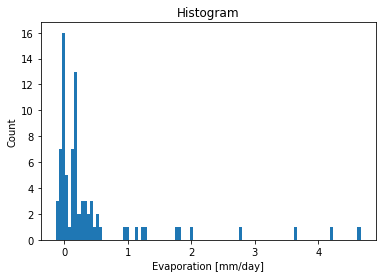

In [25]:
res3.plot.hist(bins=100)

In [26]:
res3

<xarray.DataArray 'evaporation' (i: 250)>
dask.array<shape=(250,), dtype=float32, chunksize=(250,)>
Coordinates:
    lat      (i) float32 4.62534 -40.5411 59.0418 13.4586 -64.291 -76.3743 ...
    lon      (i) float32 -11.709 -33.2923 -98.542 -162.542 -64.0421 -160.958 ...
    time     (i) datetime64[ns] 2016-12-22 2016-12-22 2016-12-22 2016-12-22 ...
Dimensions without coordinates: i
Attributes:
    long_name:      Evaporation
    project_name:   GLEAM
    references:     Martens, B., Miralles, D.G., Lievens, H., van der Schalie...
    source_name:    E
    standard_name:  water_evaporation_flux
    units:          mm/day
    url:            http://www.gleam.eu

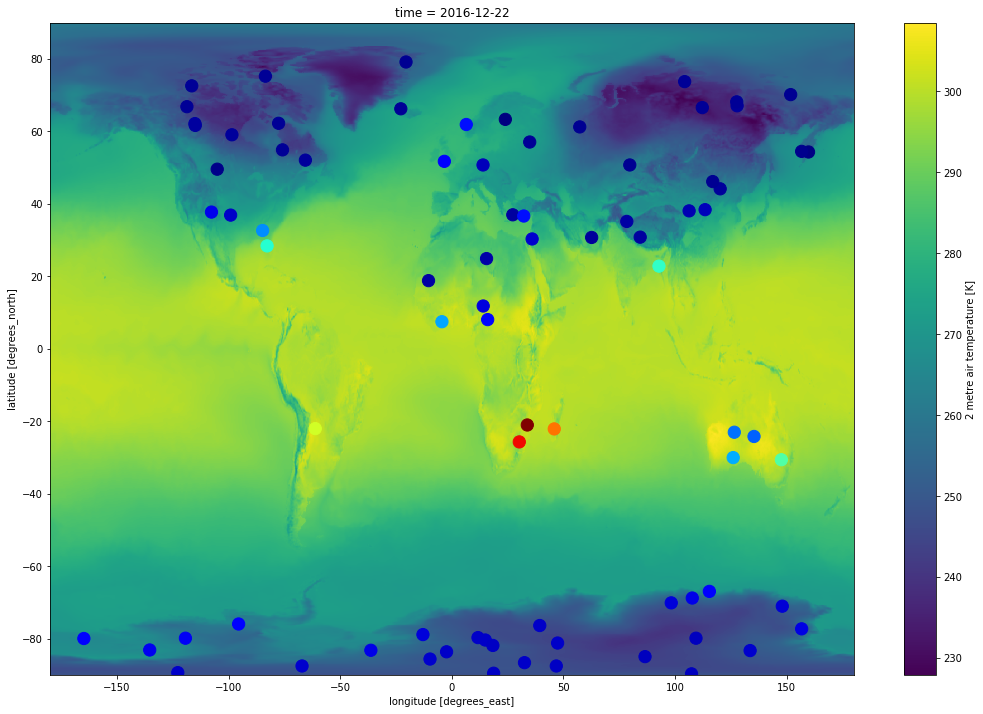

In [27]:
fig = plt.figure(figsize = (18,12))
ax = plt.subplot(111)
cube_zarr_image.air_temperature_2m.isel(time=xi.xit[0]).plot.imshow(ax=ax)
ax.scatter(res3.lon, res3.lat, c=res3.values, s=150, cmap=plt.cm.jet)

In [28]:
lonx.min()

<xarray.DataArray ()>
array(-179.59558916983238)

# same for data set

In [29]:
ds2 = cube_zarr_image[dict(time=xi.xit, lat=xi.xilat, lon = xi.xilon )]

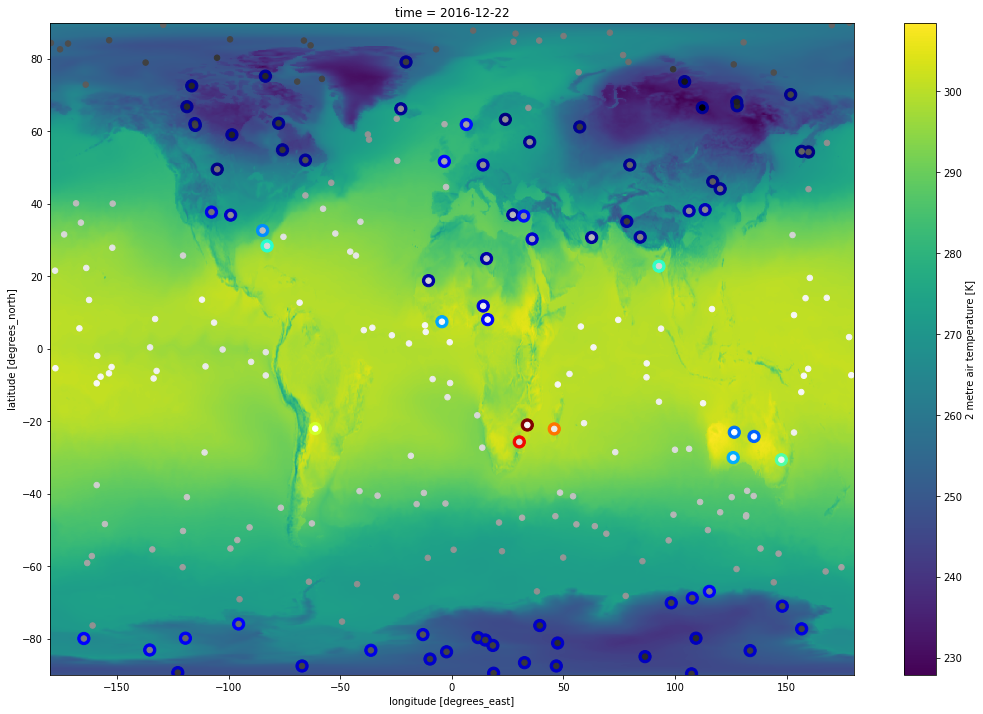

In [30]:
fig2 = plt.figure(figsize = (18,12))
ax2 = plt.subplot(111)
cube_zarr_image.air_temperature_2m.isel(time=xi.xit[0]).plot.imshow(ax=ax2)
ax2.scatter(ds2.lon, ds2.lat, c=ds2.evaporation.values, s=150, cmap=plt.cm.jet)
ax2.scatter(ds2.lon, ds2.lat, c=ds2.air_temperature_2m.values, s=30, cmap=plt.cm.gray)

In [31]:
ds = cube_zarr_image.evaporation[1700, 2000:2003,990:993]

In [32]:
ds2

<xarray.Dataset>
Dimensions:                            (bnds: 2, i: 250)
Coordinates:
    lat                                (i) float32 4.62534 -40.5411 59.0418 ...
    lat_bnds                           (i, bnds) float32 dask.array<shape=(250, 2), chunksize=(250, 2)>
    lon                                (i) float32 -11.709 -33.2923 -98.542 ...
    lon_bnds                           (i, bnds) float32 dask.array<shape=(250, 2), chunksize=(250, 2)>
    time                               (i) datetime64[ns] 2016-12-22 ...
    time_bnds                          (i, bnds) datetime64[ns] dask.array<shape=(250, 2), chunksize=(250, 2)>
Dimensions without coordinates: bnds, i
Data variables:
    AOD1600_mean                       (i) float32 dask.array<shape=(250,), chunksize=(250,)>
    AOD550_mean                        (i) float32 dask.array<shape=(250,), chunksize=(250,)>
    AOD670_mean                        (i) float32 dask.array<shape=(250,), chunksize=(250,)>
    AOD870_mean        

In [33]:
def get_macropixel_is(xin, ms=3, ts=1):
    xln = np.zeros(ms*ms*ts,dtype=int)
    xlt = np.zeros(ms*ms*ts, dtype=int)
    xt = np.zeros(ms*ms*ts, dtype=int)
    cnt = 0
    for i in range(ms):
        for j in range(ms):
            for t in range(ts):
                xln[cnt]=xin.xilon - (ms-1)/2 + i
                xlt[cnt]= xin.xilat - (ms-1)/2 + j
                xt[cnt]= xin.xit - (ts-1)/2 + t
                #print(cnt, xln[cnt], xlt[cnt],xt[cnt])
                cnt+=1
    return dict(time=xr.DataArray(xt, dims = ['i']), lat=xr.DataArray(xlt, dims = ['i']),  lon = xr.DataArray(xln, dims = ['i']))

In [34]:
xdict = get_macropixel_is(xi.isel(i=0))
mcr = cube_zarr_image[xdict]

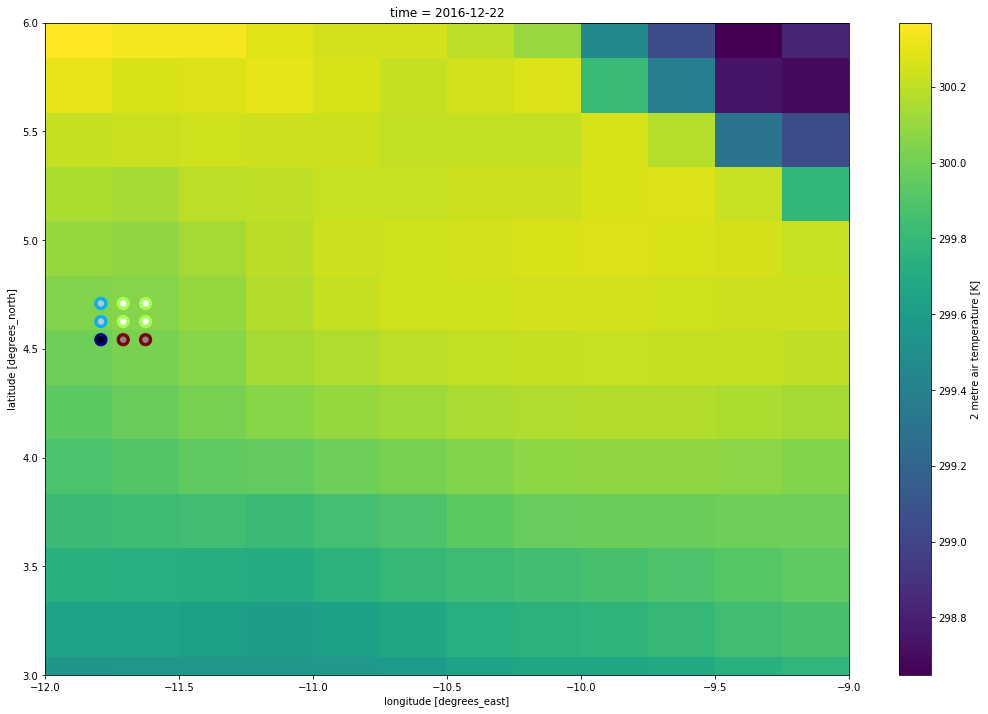

In [42]:
ig3 = plt.figure(figsize = (18,12))
ax3 = plt.subplot(111)
cube_zarr_image.air_temperature_2m.isel(time=xi.xit[0]).sel(lat=slice(6.,3.), lon=slice(-12.,-9.)).plot.imshow(ax=ax3)
ax3.scatter(mcr.lon, mcr.lat, c=mcr.max_air_temperature_2m.values, s=150, cmap=plt.cm.jet)
ax3.scatter(mcr.lon, mcr.lat, c=mcr.air_temperature_2m.values, s=30, cmap=plt.cm.gray)

In [39]:
mcr.lon

<xarray.DataArray 'lon' (i: 9)>
array([-11.792339, -11.792339, -11.792339, -11.709006, -11.709006, -11.709006,
       -11.625673, -11.625673, -11.625673], dtype=float32)
Coordinates:
    lat      (i) float32 4.70867 4.62534 4.54201 4.70867 4.62534 4.54201 ...
    lon      (i) float32 -11.7923 -11.7923 -11.7923 -11.709 -11.709 -11.709 ...
    time     (i) datetime64[ns] 2016-12-22 2016-12-22 2016-12-22 2016-12-22 ...
Dimensions without coordinates: i
Attributes:
    bounds:         lon_bnds
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [40]:
mcr.lat

<xarray.DataArray 'lat' (i: 9)>
array([ 4.708674,  4.625341,  4.542008,  4.708674,  4.625341,  4.542008,
        4.708674,  4.625341,  4.542008], dtype=float32)
Coordinates:
    lat      (i) float32 4.70867 4.62534 4.54201 4.70867 4.62534 4.54201 ...
    lon      (i) float32 -11.7923 -11.7923 -11.7923 -11.709 -11.709 -11.709 ...
    time     (i) datetime64[ns] 2016-12-22 2016-12-22 2016-12-22 2016-12-22 ...
Dimensions without coordinates: i
Attributes:
    bounds:         lat_bnds
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north